# 6.2. Проекты по применению ARIMA

In [53]:
import os
import numpy
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import DataFrame
from pandas import Grouper
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
from math import log
from math import exp
from scipy.stats import boxcox
import warnings
from statsmodels.tsa.arima.model import ARIMAResults
from matplotlib import pyplot

In [54]:
os.chdir("C:/Users/HP/Documents/analysis/TS/data/")

# Project: Monthly Armed Robberies in Boston

In [55]:
# split into a training and validation dataset
series = read_csv('robberies.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 106, Validation 12


In [56]:
# evaluate a persistence model
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=98.000, Expected=125.000
>Predicted=125.000, Expected=155.000
>Predicted=155.000, Expected=190.000
>Predicted=190.000, Expected=236.000
>Predicted=236.000, Expected=189.000
>Predicted=189.000, Expected=174.000
>Predicted=174.000, Expected=178.000
>Predicted=178.000, Expected=136.000
>Predicted=136.000, Expected=161.000
>Predicted=161.000, Expected=171.000
>Predicted=171.000, Expected=149.000
>Predicted=149.000, Expected=184.000
>Predicted=184.000, Expected=155.000
>Predicted=155.000, Expected=276.000
>Predicted=276.000, Expected=224.000
>Predicted=224.000, Expected=213.000
>Predicted=213.000, Expected=279.000
>Predicted=279.000, Expected=268.000
>Predicted=268.000, Expected=287.000
>Predicted=287.000, Expected=238.000
>Predicted=238.000, Expected=213.000
>Predicted=213.000, Expected=257.000
>Predicted=257.000, Expected=293.000
>Predicted=293.000, Expected=212.000
>Predicted=212.000, Expected=246.000
>Predicted=246.000, Expected=353.000
>Predicted=353.000, Expected=339.000
>P

In [57]:
# summary statistics of time series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
print(series.describe())

count    106.000000
mean     173.103774
std      112.231133
min       29.000000
25%       74.750000
50%      144.500000
75%      271.750000
max      487.000000
Name: 1, dtype: float64


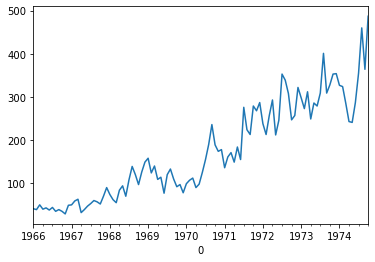

In [58]:
# line plots of time series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
series.plot()
pyplot.show()

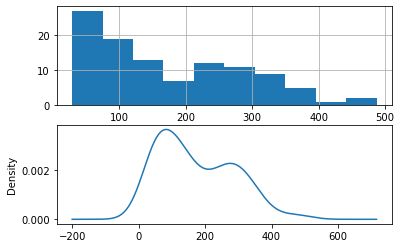

In [59]:
# density plots of time series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

0
1966-01-01     41
1966-02-01     39
1966-03-01     50
1966-04-01     40
1966-05-01     43
             ... 
1974-06-01    287
1974-07-01    355
1974-08-01    460
1974-09-01    364
1974-10-01    487
Name: 1, Length: 106, dtype: int64


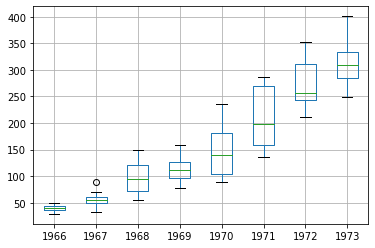

In [60]:
# boxplots of time series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
print(series)
groups = series['1966':'1973'].groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot()
pyplot.show()

In [61]:
# statistical test for the stationarity of the time series
# create a differenced time series
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return Series(diff)

series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv', header=False)

ADF Statistic: -3.980946
p-value: 0.001514
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


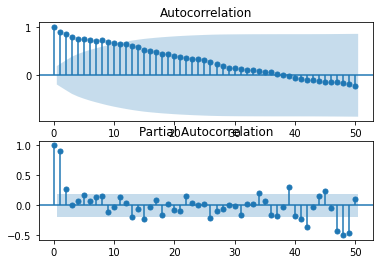

In [62]:
# ACF and PACF plots of time series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, lags=50, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, lags=50, ax=pyplot.gca())
pyplot.show()

In [63]:
# evaluate manually configured ARIMA model
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(0,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=99.923, Expected=125.000
>Predicted=116.442, Expected=155.000
>Predicted=139.962, Expected=190.000
>Predicted=176.933, Expected=236.000
>Predicted=232.851, Expected=189.000
>Predicted=184.697, Expected=174.000
>Predicted=180.705, Expected=178.000
>Predicted=179.873, Expected=136.000
>Predicted=141.098, Expected=161.000
>Predicted=166.173, Expected=171.000
>Predicted=167.005, Expected=149.000
>Predicted=150.656, Expected=184.000
>Predicted=182.314, Expected=155.000
>Predicted=154.213, Expected=276.000
>Predicted=245.214, Expected=224.000
>Predicted=225.902, Expected=213.000
>Predicted=216.867, Expected=279.000
>Predicted=258.698, Expected=268.000
>Predicted=263.377, Expected=287.000
>Predicted=279.945, Expected=238.000
>Predicted=251.485, Expected=213.000
>Predicted=226.574, Expected=257.000
>Predicted=249.690, Expected=293.000
>Predicted=277.211, Expected=212.000
>Predicted=230.020, Expected=246.000
>Predicted=245.786, Expected=353.000
>Predicted=317.992, Expected=339.000
>P

In [64]:
# Grid Search пропустила

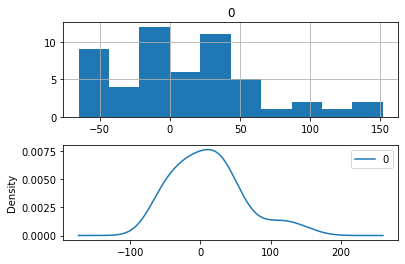

In [65]:
# plot residual errors for ARIMA model
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(0,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

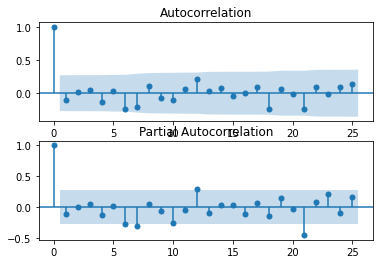

In [66]:
# ACF and PACF plots of forecast residual errors
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(0,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, lags=25, ax=pyplot.gca())
pyplot.show()

Lambda: 0.260060


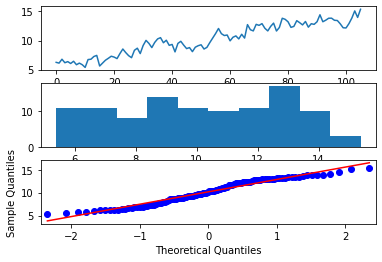

In [67]:
# plots of box-cox transformed dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
transformed, lam = boxcox(X)
print('Lambda: %f' % lam)
pyplot.figure(1)
# line plot
pyplot.subplot(311)
pyplot.plot(transformed)
# histogram
pyplot.subplot(312)
pyplot.hist(transformed)
# q-q plot
pyplot.subplot(313)
qqplot(transformed, line='r', ax=pyplot.gca())
pyplot.show()

In [68]:
numpy.seterr(divide='ignore', invalid='ignore', over='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [69]:
# evaluate ARIMA models with box-cox transformed time series
# invert box-cox transform
def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# transform
	transformed, lam = boxcox(history)
	if lam < -5:
		transformed, lam = history, 1
	# predict
	model = ARIMA(transformed, order=(0,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	# invert transformed prediction
	yhat = boxcox_inverse(yhat, lam)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=99.650, Expected=125.000
>Predicted=115.208, Expected=155.000
>Predicted=136.143, Expected=190.000
>Predicted=165.532, Expected=236.000
>Predicted=206.571, Expected=189.000
>Predicted=180.934, Expected=174.000
>Predicted=178.202, Expected=178.000
>Predicted=179.316, Expected=136.000
>Predicted=145.466, Expected=161.000
>Predicted=165.565, Expected=171.000
>Predicted=166.484, Expected=149.000
>Predicted=152.066, Expected=184.000
>Predicted=179.561, Expected=155.000
>Predicted=155.211, Expected=276.000
>Predicted=238.942, Expected=224.000
>Predicted=210.748, Expected=213.000
>Predicted=214.075, Expected=279.000
>Predicted=257.446, Expected=268.000
>Predicted=255.413, Expected=287.000
>Predicted=275.941, Expected=238.000
>Predicted=245.092, Expected=213.000
>Predicted=226.699, Expected=257.000
>Predicted=252.343, Expected=293.000
>Predicted=275.301, Expected=212.000
>Predicted=224.657, Expected=246.000
>Predicted=248.227, Expected=353.000
>Predicted=313.578, Expected=339.000
>P

# Project: Annual Water Usage in Baltimore

In [70]:
# separate out a validation dataset
series = read_csv('water.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 69, Validation 10


In [71]:
# evaluate a persistence model
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=522.000
>Predicted=522.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=450.000
>Predicted=450.000, Expected=432.000
>Predicted=432.000, Expected=432.000
>Predicted=432.000, Expected=458.000
>Predicted=458.000, Expected=462.000
>Predicted=462.000, Expected=503.000
>Predicted=503.000, Expected=488.000
>Predicted=488.000, Expected=466.000
>Predicted=466.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=500.000
>Predicted=500.000, Expected=522.000
>Predicted=522.000, Expected=575.000
>Predicted=575.000, Expected=583.000
>Predicted=583.000, Expected=587.000
>Predicted=587.000, Expected=628.000
>Predicted=628.000, Expected=640.000
>Predicted=640.000, Expected=609.000
>Predicted=609.000, Expected=606.000
>

In [72]:
# summary statistics of time series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
print(series.describe())

count     69.000000
mean     500.478261
std       73.901685
min      344.000000
25%      458.000000
50%      492.000000
75%      538.000000
max      662.000000
Name: 1, dtype: float64


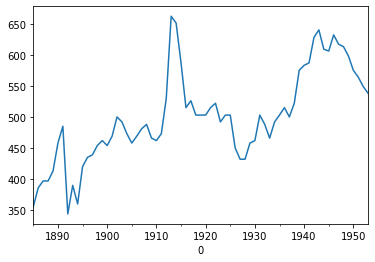

In [73]:
# line plot of time series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
series.plot()
pyplot.show()

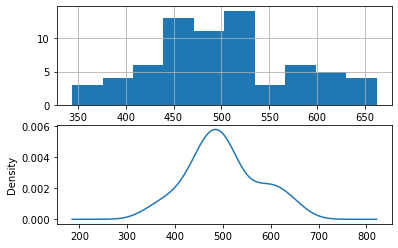

In [74]:
# density plots of time series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

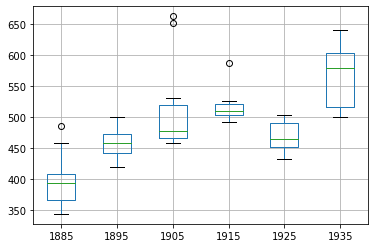

In [75]:
# boxplots of time series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
groups = series.groupby(Grouper(freq='10YS'))
decades = DataFrame()
for name, group in groups:
	if len(group.values) is 10:
		decades[name.year] = group.values
decades.boxplot()
pyplot.show()

ADF Statistic: -6.126719
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


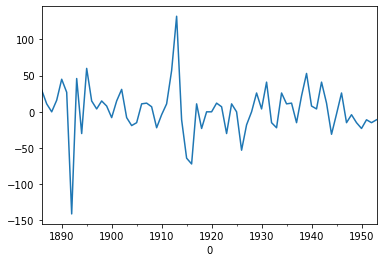

In [76]:
# create and summarize a stationary version of the time series
# create a differenced series
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return Series(diff)

series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# plot differenced data
stationary.plot()
pyplot.show()
# save
stationary.to_csv('stationary.csv', header=False)

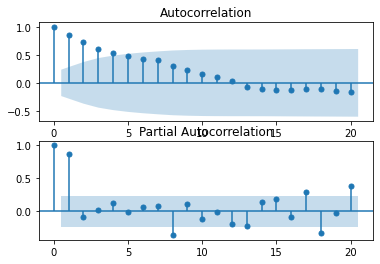

In [77]:
# ACF and PACF plots of the time series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, lags=20, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, lags=20, ax=pyplot.gca())
pyplot.show()

In [78]:
# evaluate a manually configured ARIMA model
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(4,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=530.101, Expected=503.000
>Predicted=511.154, Expected=503.000
>Predicted=515.637, Expected=515.000
>Predicted=520.904, Expected=522.000
>Predicted=525.009, Expected=492.000
>Predicted=492.360, Expected=503.000
>Predicted=504.664, Expected=503.000
>Predicted=512.082, Expected=450.000
>Predicted=454.312, Expected=432.000
>Predicted=441.329, Expected=432.000
>Predicted=452.418, Expected=458.000
>Predicted=470.223, Expected=462.000
>Predicted=465.860, Expected=503.000
>Predicted=498.112, Expected=488.000
>Predicted=483.399, Expected=466.000
>Predicted=455.128, Expected=492.000
>Predicted=492.320, Expected=503.000
>Predicted=503.711, Expected=515.000
>Predicted=505.815, Expected=500.000
>Predicted=493.165, Expected=522.000
>Predicted=515.482, Expected=575.000
>Predicted=571.332, Expected=583.000
>Predicted=568.102, Expected=587.000
>Predicted=567.410, Expected=628.000
>Predicted=620.638, Expected=640.000
>Predicted=632.546, Expected=609.000
>Predicted=594.338, Expected=606.000
>

In [79]:
# grid search ARIMA parameters for a time series
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		# model_fit = model.fit(disp=0)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


               0
count  35.000000
mean    1.081458
std    22.022201
min   -52.104849
25%   -16.209637
50%    -0.454858
75%    12.089062
max    51.281127


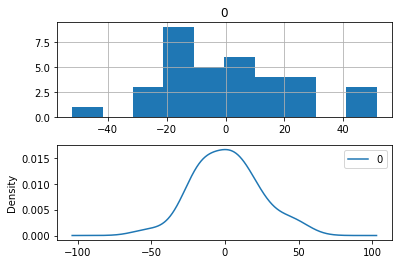

In [80]:
# summarize residual errors for an ARIMA model
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

RMSE: 21.705
               0
count  35.000000
mean   -0.000166
std    22.022201
min   -53.186473
25%   -17.291261
50%    -1.536482
75%    11.007438
max    50.199503


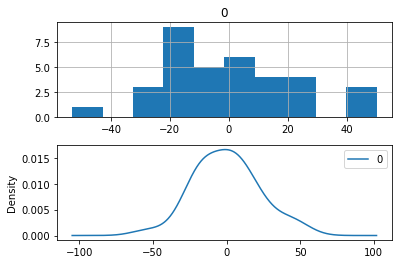

In [81]:
# summarize residual errors from bias corrected forecasts
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 1.081624
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit()
	yhat = bias + float(model_fit.forecast()[0])
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot residual errors
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

In [82]:
# save finalized model to file
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
# fit model
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit()
# bias constant, could be calculated from in-sample mean residual
bias = 1.081624
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

In [83]:
# load finalized model and make a prediction
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = bias + float(model_fit.forecast()[0])
print('Predicted: %.3f' % yhat)

Predicted: 540.011


>Predicted=540.011, Expected=568.000
>Predicted=571.593, Expected=575.000
>Predicted=573.292, Expected=579.000
>Predicted=579.562, Expected=587.000
>Predicted=588.064, Expected=602.000
>Predicted=603.025, Expected=594.000
>Predicted=593.177, Expected=587.000
>Predicted=588.556, Expected=587.000
>Predicted=588.796, Expected=625.000
>Predicted=627.947, Expected=613.000
RMSE: 16.533


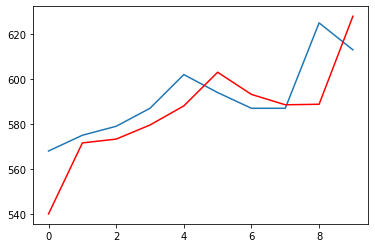

In [84]:
# load and evaluate the finalized model on the validation dataset
# load and prepare datasets
dataset = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit()
	yhat = bias + float(model_fit.forecast()[0])
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

# Project: Monthly Sales of French Champagne

In [85]:
# separate out a validation dataset
series = read_csv('champagne.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 93, Validation 12


In [86]:
# evaluate persistence model on time series
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=5428.000, Expected=8314
>Predicted=8314.000, Expected=10651
>Predicted=10651.000, Expected=3633
>Predicted=3633.000, Expected=4292
>Predicted=4292.000, Expected=4154
>Predicted=4154.000, Expected=4121
>Predicted=4121.000, Expected=4647
>Predicted=4647.000, Expected=4753
>Predicted=4753.000, Expected=3965
>Predicted=3965.000, Expected=1723
>Predicted=1723.000, Expected=5048
>Predicted=5048.000, Expected=6922
>Predicted=6922.000, Expected=9858
>Predicted=9858.000, Expected=11331
>Predicted=11331.000, Expected=4016
>Predicted=4016.000, Expected=3957
>Predicted=3957.000, Expected=4510
>Predicted=4510.000, Expected=4276
>Predicted=4276.000, Expected=4968
>Predicted=4968.000, Expected=4677
>Predicted=4677.000, Expected=3523
>Predicted=3523.000, Expected=1821
>Predicted=1821.000, Expected=5222
>Predicted=5222.000, Expected=6872
>Predicted=6872.000, Expected=10803
>Predicted=10803.000, Expected=13916
>Predicted=13916.000, Expected=2639
>Predicted=2639.000, Expected=2899
>Predicted=2

In [87]:
# summary statistics of time series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
print(series.describe())

count       93.000000
mean      4641.118280
std       2486.403841
min       1573.000000
25%       3036.000000
50%       4016.000000
75%       5048.000000
max      13916.000000
Name: 1, dtype: float64


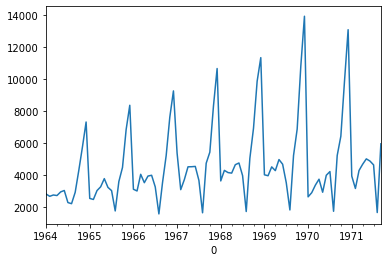

In [88]:
# line plot of time series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
series.plot()
pyplot.show()

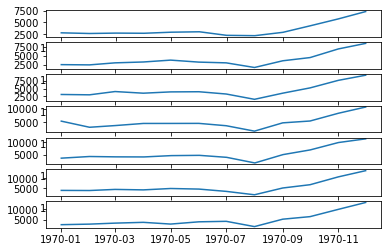

In [89]:
# multiple line plots of time series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
groups = series['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
	pyplot.subplot((n_groups*100) + 10 + i)
	i += 1
	pyplot.plot(group)
pyplot.show()

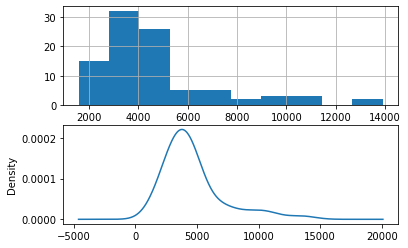

In [90]:
# density plots of time series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

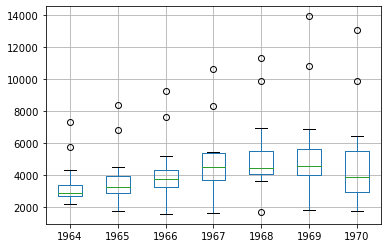

In [91]:
# boxplots of time series
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
groups = series['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot()
pyplot.show()

ADF Statistic: -7.134898
p-value: 0.000000
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586


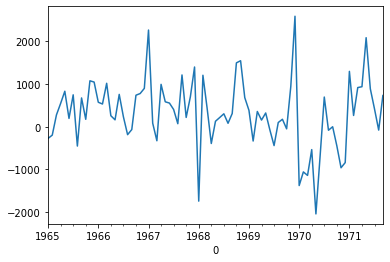

In [92]:
# create and summarize stationary version of time series
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv', header=False)
# plot
stationary.plot()
pyplot.show()

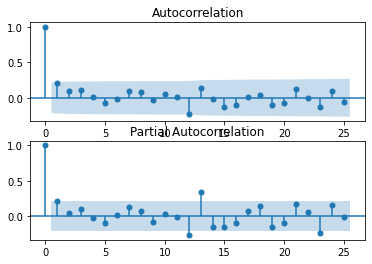

In [93]:
# ACF and PACF plots of time series
series = read_csv('stationary.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, lags=25, ax=pyplot.gca())
pyplot.show()

In [94]:
# evaluate manually configured ARIMA model
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=8076.987, Expected=8314.000
>Predicted=9747.154, Expected=10651.000
>Predicted=5994.362, Expected=3633.000
>Predicted=3820.287, Expected=4292.000
>Predicted=4041.968, Expected=4154.000
>Predicted=4990.405, Expected=4121.000
>Predicted=5129.641, Expected=4647.000
>Predicted=5031.196, Expected=4753.000
>Predicted=4133.285, Expected=3965.000
>Predicted=2095.321, Expected=1723.000
>Predicted=5216.271, Expected=5048.000
>Predicted=5866.317, Expected=6922.000
>Predicted=8591.060, Expected=9858.000
>Predicted=11028.649, Expected=11331.000
>Predicted=4090.352, Expected=4016.000
>Predicted=4767.109, Expected=3957.000
>Predicted=4656.326, Expected=4510.000
>Predicted=4577.708, Expected=4276.000
>Predicted=5108.656, Expected=4968.000
>Predicted=5202.831, Expected=4677.000
>Predicted=4423.982, Expected=3523.000
>Predicted=2162.388, Expected=1821.000
>Predicted=5463.233, Expected=5222.000
>Predicted=7331.345, Expected=6872.000
>Predicted=10258.650, Expected=10803.000
>Predicted=11732.476

In [95]:
# grid search ARIMA parameters for time series
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=947.677
ARIMA(0, 0, 1) RMSE=948.007
ARIMA(0, 0, 2) RMSE=973.907
ARIMA(0, 0, 3) RMSE=987.021
ARIMA(0, 0, 4) RMSE=1008.705
ARIMA(0, 0, 5) RMSE=1038.189
ARIMA(0, 0, 6) RMSE=1059.502
ARIMA(0, 1, 0) RMSE=1145.923
ARIMA(0, 1, 1) RMSE=959.122
ARIMA(0, 1, 2) RMSE=958.613
ARIMA(0, 1, 3) RMSE=976.966
ARIMA(0, 1, 4) RMSE=982.294
ARIMA(0, 1, 5) RMSE=1013.386
ARIMA(0, 1, 6) RMSE=1061.510
ARIMA(0, 2, 0) RMSE=1930.801
ARIMA(0, 2, 1) RMSE=1157.260
ARIMA(0, 2, 2) RMSE=961.470
ARIMA(0, 2, 3) RMSE=981.115
ARIMA(0, 2, 4) RMSE=982.052
ARIMA(0, 2, 5) RMSE=1068.814
ARIMA(0, 2, 6) RMSE=1054.055
ARIMA(1, 0, 0) RMSE=945.107
ARIMA(1, 0, 1) RMSE=979.319
ARIMA(1, 0, 2) RMSE=975.267
ARIMA(1, 0, 3) RMSE=997.229
ARIMA(1, 0, 4) RMSE=1032.134
ARIMA(1, 0, 5) RMSE=1072.922
ARIMA(1, 0, 6) RMSE=1068.549
ARIMA(1, 1, 0) RMSE=1071.385
ARIMA(1, 1, 1) RMSE=961.549
ARIMA(1, 1, 2) RMSE=962.006
ARIMA(1, 1, 3) RMSE=962.202
ARIMA(1, 1, 4) RMSE=986.987
ARIMA(1, 1, 5) RMSE=1006.845
ARIMA(1, 1, 6) RMSE=1049.784
ARIM

                 0
count    47.000000
mean   -204.270105
std     935.746182
min   -2325.393963
25%    -709.042279
50%    -228.936186
75%     333.614664
max    2191.022449


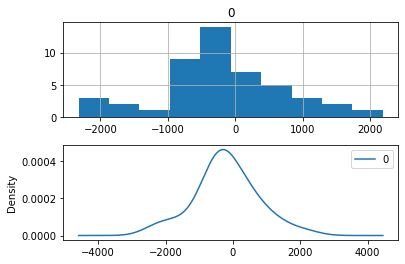

In [96]:
# summarize ARIMA forecast residuals
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

RMSE: 997.006
                 0
count    47.000000
mean   -370.174833
std     935.746182
min   -2491.298691
25%    -874.947007
50%    -394.840914
75%     167.709936
max    2025.117721


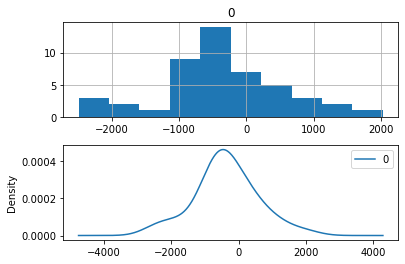

In [97]:
# plots of residual errors of bias corrected forecasts
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 165.904728
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

                 0
count    47.000000
mean   -204.270105
std     935.746182
min   -2325.393963
25%    -709.042279
50%    -228.936186
75%     333.614664
max    2191.022449


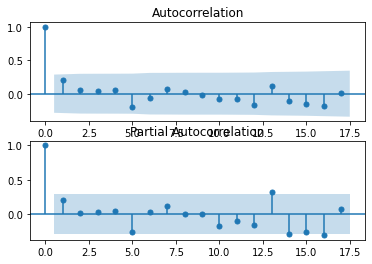

In [98]:
# ACF and PACF plots of residual errors of bias corrected forecasts
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

In [99]:
# save finalized model
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(0,0,1))
model_fit = model.fit()
# bias constant, could be calculated from in-sample mean residual
bias = 165.904728
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

In [100]:
# load finalized model and make a prediction
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 7004.078


>Predicted=7004.078, Expected=6981.000
>Predicted=10356.627, Expected=9851.000
>Predicted=13493.317, Expected=12670.000
>Predicted=4278.689, Expected=4348.000
>Predicted=3684.166, Expected=3564.000
>Predicted=4772.002, Expected=4577.000
>Predicted=5147.157, Expected=4788.000
>Predicted=5446.633, Expected=4618.000
>Predicted=5209.065, Expected=5312.000
>Predicted=5153.854, Expected=4298.000
>Predicted=1988.539, Expected=1413.000
>Predicted=6326.844, Expected=5877.000
RMSE: 506.921


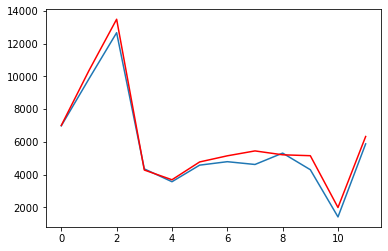

In [101]:
# load and evaluate the finalized model on the validation dataset
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load and prepare datasets
dataset = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()